In [62]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 1000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .5, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
# for t in range(n_treatments):
#     T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0] + U[:, 0] + Z[:, t]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [ ]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LassoCV, Lasso, MultiTaskLassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
cv = KFold(n_splits=2, shuffle=True)
cv = list(cv.split(X))
for t in range(y.shape[1]):
    y[:, t] = y[:, t] - cross_val_predict(LassoCV(), X, y[:, t], cv=cv)
for t in range(T.shape[1]):
    T[:, t] = T[:, t] - cross_val_predict(RandomForestClassifier(min_samples_leaf=40), X, T[:, t],
                                          cv=cv, method='predict_proba')[:, 1]

# Ensemble Estimator fit

In [63]:
from econml.tree import Tree
from econml.grf import LinearMomentGRFCriterionMSE, LinearMomentGRFCriterion
from econml.tree import BestSplitter
from econml.tree import DepthFirstTreeBuilder
from sklearn.model_selection import train_test_split
import numpy as np


def fit(X, y, n_features, n_outputs, random_state, 
        criterion='het',
        max_depth = 100,
        min_samples_leaf = 100,
        min_balancedness_tol = .3,
        min_impurity_decrease=-np.inf, 
        subsample_fr=.7, replace=False, 
        honest=True):
    min_samples_split = 2
    min_weight_leaf = 0
    max_features = n_features
    n_outputs = n_outputs
    n_samples = X.shape[0]

    random_state = np.random.RandomState(random_state)
    inds = random_state.choice(X.shape[0], int(np.ceil(subsample_fr * X.shape[0])), replace=replace)
    sample_weight = np.zeros(X.shape[0])
    sample_weight[inds] = 1

    if honest:
        Xtrain, Xval, ytrain, yval,\
            sample_weight_train, sample_weight_val, inds_train, inds_val = train_test_split(X, y, sample_weight,
                                                                                            np.arange(X.shape[0]),
                                                                                            train_size=.5,
                                                                                            random_state=random_state)
    else:
        Xtrain, Xval, ytrain, yval,\
            sample_weight_train, sample_weight_val, inds_train, inds_val = X, X, y, y, sample_weight, sample_weight,\
            np.arange(X.shape[0]), np.arange(X.shape[0])
    tree = Tree(n_features, n_outputs, store_jac=True)
    if criterion == 'het':
        criterion = LinearMomentGRFCriterion(n_outputs, n_features, Xtrain.shape[0], Xval.shape[0])
    else:
        criterion = LinearMomentGRFCriterionMSE(n_outputs, n_features, Xtrain.shape[0], Xval.shape[0])
    splitter = BestSplitter(criterion, max_features, min_samples_leaf, min_weight_leaf,
                            min_balancedness_tol, random_state)
    builder = DepthFirstTreeBuilder(splitter, min_samples_split, min_samples_leaf, min_weight_leaf,
                                    max_depth, min_impurity_decrease)
    builder.build(tree, Xtrain, ytrain, Xval, yval, n_features,
                  sample_weight=sample_weight_train, sample_weight_val=sample_weight_val, store_jac=True)
    if honest:
        sample_weight[inds_train] = 0
    return tree, sample_weight

# Comparison with RF running time

In [64]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=20, n_jobs=-1, verbose=1).fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


# Fitting without Instrument

In [80]:
from econml.utilities import cross_product
from joblib.parallel import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

Taug = np.hstack([T, np.ones((T.shape[0], 1))])
n_features = X.shape[1]
n_outputs = Taug.shape[1]
alpha = y * Taug
pointJ = cross_product(Taug, Taug)
Data = np.asfortranarray(np.hstack([X, alpha, pointJ]))
random_state = np.random.RandomState(123)
forest = Parallel(n_jobs=-1, backend='threading', verbose=1)(
                    delayed(fit)(Data, y, n_features, n_outputs,
                                 random_state.randint(np.iinfo(np.int32).max),
                                 criterion='het',
                                 max_depth = 10,
                                 min_samples_leaf = 20,
                                 min_balancedness_tol = .3,
                                 min_impurity_decrease=0,
                                 subsample_fr=.7, replace=False, honest=True) for _ in range(100))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


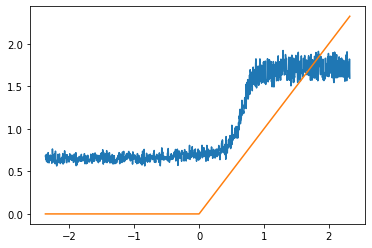

In [81]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest), axis=0)[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [82]:
alpha_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_precond)(X_test) for tree, _ in forest), axis=0)
J_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_jac)(X_test) for tree, _ in forest), axis=0)
pred_test_tree = np.einsum('ijk,ik->ij',
                           np.linalg.pinv(J_test_tree.reshape(-1, alpha_test_tree.shape[1], alpha_test_tree.shape[1])),
                           alpha_test_tree)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


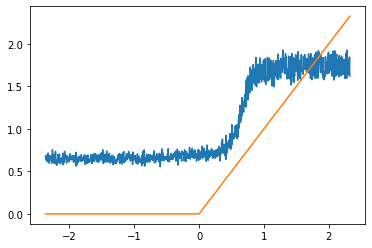

In [83]:
###### import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test_tree[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

# Fitting with honesty

In [113]:
from econml.utilities import cross_product
from joblib.parallel import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

Taug = np.hstack([T, np.ones((T.shape[0], 1))])
Zaug = np.hstack([Z, np.ones((Z.shape[0], 1))])
n_features = X.shape[1]
n_outputs = Taug.shape[1]
alpha = y * Zaug
pointJ = cross_product(Zaug, Taug)
Data = np.asfortranarray(np.hstack([X, alpha, pointJ]))
random_state = np.random.RandomState(1233)
forest = Parallel(n_jobs=-1, backend='threading', verbose=1)(
                    delayed(fit)(Data, y, n_features, n_outputs,
                                 random_state.randint(np.iinfo(np.int32).max),
                                 criterion='mse',
                                 max_depth = 100,
                                 min_samples_leaf = 20,
                                 min_balancedness_tol = .3,
                                 min_impurity_decrease = 0,
                                 subsample_fr=.9, replace=False, honest=True) for _ in range(1000))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


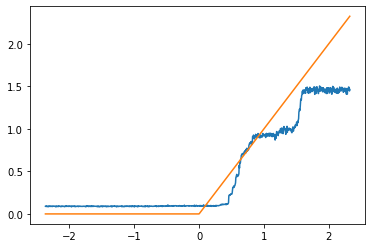

In [114]:
import matplotlib.pyplot as plt
pred_test_point = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                                                                              for tree, _ in forest), axis=0)
plt.plot(X_test[:, 0], pred_test_point[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [115]:
np.unique(np.concatenate([tree.feature for tree, _ in forest]), return_counts=True)

(array([-2,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64),
 array([3467, 1477,  188,  102,   66,  134,  198,   65,   98,   63,   76],
       dtype=int64))

In [116]:
np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_importances)(normalize=True) for tree, _ in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


array([0.5036205 , 0.09262214, 0.04254384, 0.02068349, 0.07647897,
       0.11908361, 0.02328731, 0.05414858, 0.02735904, 0.04017253])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


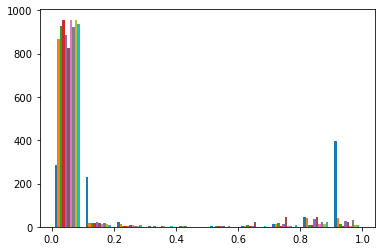

In [117]:
plt.hist(np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_importances)(normalize=True) for tree, _ in forest)))
plt.show()

In [118]:
np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_heterogeneity_importances)(normalize=True) for tree, _ in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


array([0.89292498, 0.00435232, 0.01551719, 0.00959133, 0.01349247,
       0.02744193, 0.01263384, 0.01003437, 0.0062776 , 0.00773397])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


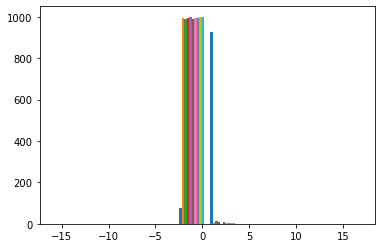

In [119]:
plt.hist(np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_heterogeneity_importances)(normalize=True) for tree, _ in forest)))
plt.show()

In [120]:
forest[0][0].impurity[:10]

array([ 8.63932708,  6.77651198, 14.3374292 ,  8.92824717,  6.73499219])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


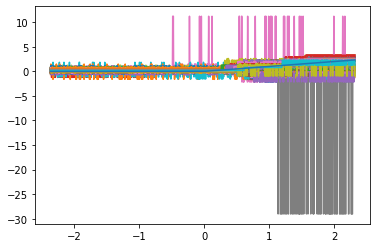

In [121]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest))[:, :, 0].T)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

### Inverse of average Jacobian instead of average of inverses

In [122]:
alpha_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_precond)(X_test) for tree, _ in forest), axis=0)
J_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_jac)(X_test) for tree, _ in forest), axis=0)
pred_test_tree = np.einsum('ijk,ik->ij',
                           np.linalg.pinv(J_test_tree.reshape(-1, alpha_test_tree.shape[1], alpha_test_tree.shape[1])),
                           alpha_test_tree)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


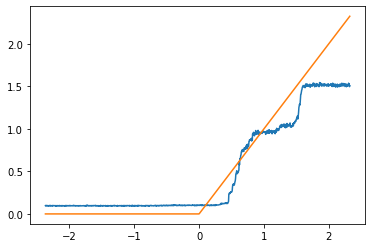

In [123]:
###### import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test_tree[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [53]:
def predict(tree, X_test, X_train, alpha_train, pointJ_train, sample_weight_train):
    kernel = tree.apply(X_test).reshape(-1, 1) == tree.apply(X_train).reshape(1, -1)
    kernel = kernel * sample_weight_train.reshape(1, -1)
    kernel_norm = np.sum(kernel, axis=1, keepdims=True)
    alpha_test = kernel @ alpha_train / kernel_norm
    J_test = kernel @ pointJ / kernel_norm
    return np.hstack([alpha_test, J_test])

alphaJ_test = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(predict)(tree, X_test, X, alpha, pointJ, sample_weight)
                 for tree, sample_weight in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.4s finished


In [54]:
alpha_test, J_test = alphaJ_test[:, :alpha.shape[1]], alphaJ_test[:, alpha.shape[1]:]
pred_test = np.einsum('ijk,ik->ij', np.linalg.pinv(J_test.reshape(-1, alpha.shape[1], alpha.shape[1])), alpha_test)

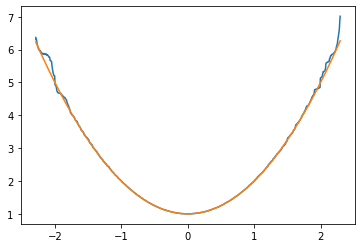

In [55]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [56]:
np.testing.assert_almost_equal(alpha_test, alpha_test_tree)
np.testing.assert_almost_equal(J_test, J_test_tree)
np.testing.assert_almost_equal(pred_test, pred_test_tree)

### Feature importances

In [229]:
np.nanmean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_importances)(normalize=True) for tree, _ in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


array([0.58 , 0.028, 0.037, 0.047, 0.029, 0.047, 0.12 , 0.02 , 0.074,
       0.018])

# Comparison with ORF and Current Causal Forest

In [90]:
from econml.dml import ForestDML
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
est = ForestDML(model_y=RandomForestRegressor(min_samples_leaf=100),
                model_t=RandomForestRegressor(min_samples_leaf=100),
                n_estimators=1000, min_samples_leaf=20, subsample_fr=.9,
                max_depth=100, verbose=0, n_jobs=-1).fit(y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Paral

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]

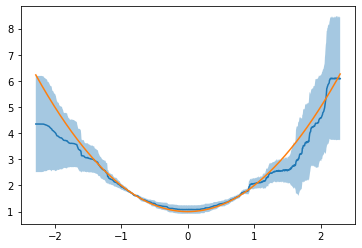

In [91]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], est.const_marginal_effect(X_test)[:, 0, 0])
plt.fill_between(X_test[:, 0],
                 *map(lambda x: x[:, 0, 0], est.const_marginal_effect_interval(X_test, alpha=0.01)), alpha=.4)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [137]:
from econml.causal_forest import CausalForest
from sklearn.linear_model import Lasso, MultiTaskLasso
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedMultiTaskLasso

est = CausalForest(n_trees=100, subsample_ratio=.9, min_leaf_size=20,
                   max_depth=100, model_T=WeightedMultiTaskLasso(), model_Y=WeightedLasso()).fit(y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.7s finished


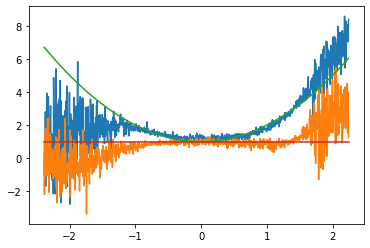

In [138]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], est.const_marginal_effect(X_test)[:, 0])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [ ]:
from econml.ortho_forest import DMLOrthoForest
from sklearn.linear_model import Lasso, MultiTaskLasso
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedMultiTaskLasso

est = DMLOrthoForest(n_trees=100, subsample_ratio=.9, min_leaf_size=20,
                     max_depth=100, model_T=WeightedMultiTaskLasso(), model_Y=WeightedLasso()).fit(y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], est.const_marginal_effect(X_test)[:, 0])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()